In [3]:
import tensorflow as tf
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt

%matplotlib inline

NUM_FEATURES = (2 * 4) + 1
NUM_LABELS = 2

## Load Training data
train = pandas.read_csv("../datasets/output/WallSt-FinalTradingHour/WallSt-FinalTradingHour_train.csv", header=None)
val = pandas.read_csv("../datasets/output/WallSt-FinalTradingHour/WallSt-FinalTradingHour_val.csv", header=None)
test = pandas.read_csv("../datasets/output/WallSt-FinalTradingHour/WallSt-FinalTradingHour_test.csv", header=None)

train = pandas.concat([train, val])
train = pandas.concat([train, test[250:]])
test = test[:250]
          
def split(data, num_features):    
    return data.values[:,:num_features], data.values[:,num_features:]

train_X, train_y = split(train, NUM_FEATURES)
val_X, val_y = split(test, NUM_FEATURES)
test_X, test_y = split(test, NUM_FEATURES)


In [5]:
train.shape[0]

1294

In [3]:
##### #Define the architecture
HIDDEN_UNITS = 32

# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES))
train_labels_node = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
lam = tf.placeholder(tf.float32)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized. 
# TODO : These should be pulled from a config file

Theta1 = tf.Variable( tf.truncated_normal([HIDDEN_UNITS, (NUM_FEATURES)], stddev=0.1))

Theta2 = tf.Variable( tf.truncated_normal([NUM_LABELS, HIDDEN_UNITS],stddev=0.1))
bias2 = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    
print('Done')

Done


In [4]:
def model(X, Theta1, Theta2, bias):
    """The Model definition."""
    # Perceptron
    
    layer1 = tf.nn.sigmoid(tf.matmul(X, tf.transpose(Theta1)))
                        
    output = tf.nn.bias_add(tf.matmul(layer1, tf.transpose(Theta2)),bias)

    return output
    
print('Done')

Done


In [5]:
yhat = model(train_data_node, Theta1, Theta2, bias2)

# Change the weights by subtracting derivative with respect to that weight
loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=train_labels_node, logits=yhat))
# Regularization using L2 Loss function 
regularizer = tf.nn.l2_loss(Theta1) + tf.nn.l2_loss(Theta2)
reg = (lam / tf.to_float(tf.shape(train_labels_node)[0])) * regularizer
loss_reg = loss + reg

# Optimizer: 

# Gradient Descent
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_reg, options={'maxiter':4000})
#update_weights = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions
train_prediction = tf.sigmoid(yhat)

print('Done')

Done


In [6]:
# Keep track of the loss at each iteration so we can chart it later
J = []

def loss_callback():
    print "Recalc..."
    
def step_callback(params):
    J.append(params)
    
def minimize(feed_dict, train=True):
    
    #optimizer.minimize(feed_dict=feed_dict, fetches=[loss_reg], loss_callback=loss_callback)
    if (train):
        optimizer.minimize(feed_dict=feed_dict)

    return loss.eval(feed_dict), train_prediction.eval(feed_dict)

def predict(data_X, data_y, lam1, threshold):    
    loss, predictions = minimize({train_data_node: data_X, train_labels_node: data_y, lam: lam1}, train=False)
    a = np.argmax(predictions,axis=1) 
    b = np.argmax(data_y,axis=1) 
    a = a[(predictions > threshold).any(axis=1)]
    b = b[(predictions > threshold).any(axis=1)]
    precision = np.float32(np.sum(a == b) / np.float32(b.shape[0]))
    recall = np.float32(np.sum(a == b) / np.float32(data_y.shape[0])) # Correct Recall
    recall = np.float32(b.shape[0]) / data_y.shape[0] # Number of Days traded
    F_score = (2.0 * precision * recall) / (precision + recall)
    return loss, precision, recall, F_score

def train(train_dict, val_dict, threshold, iterations=50):
    
    metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }
    
    print "Training",
    
    for i in range(0,iterations):
        
        while True:
            
            # Create a new interactive session that we'll use in
            # subsequent code cells.
            s = tf.InteractiveSession()
            s.as_default()

            # Initialize all the variables we defined above.
            tf.global_variables_initializer().run()

            minimize(train_dict)
            train_loss, train_precision, train_recall, train_f = predict(train_dict[train_data_node], train_dict[train_labels_node], train_dict[lam], threshold)

            if (train_loss < .65):
                print ".",
                metrics["train_loss"].append(train_loss)
                metrics["train_precision"].append(train_precision)
                metrics["train_recall"].append(train_recall)
                metrics["train_f"].append(train_f)

                val_loss, val_precision, val_recall, val_f = predict(val_dict[train_data_node], val_dict[train_labels_node], val_dict[lam], threshold)

                metrics["val_loss"].append(val_loss)
                metrics["val_precision"].append(val_precision)
                metrics["val_recall"].append(val_recall)
                metrics["val_f"].append(val_f)
                break;
    
    results = {
        "train_loss": {"mean":np.nanmean(metrics["train_loss"]), "std":np.nanstd(metrics["train_loss"]), "values":metrics["train_loss"]},
        "train_precision": {"mean":np.nanmean(metrics["train_precision"]), "std":np.nanstd(metrics["train_precision"]), "values":metrics["train_precision"]},
        "train_recall": {"mean":np.nanmean(metrics["train_recall"]), "std":np.nanstd(metrics["train_recall"]), "values":metrics["train_recall"]},
        "train_f": {"mean":np.nanmean(metrics["train_f"]), "std":np.nanstd(metrics["train_f"]), "values":metrics["train_f"]},
        "val_loss": {"mean":np.nanmean(metrics["val_loss"]), "std":np.nanstd(metrics["val_loss"]), "values":metrics["val_loss"]},
        "val_precision":{"mean":np.nanmean(metrics["val_precision"]), "std":np.nanstd(metrics["val_precision"]), "values":metrics["val_precision"]},
        "val_recall": {"mean":np.nanmean(metrics["val_recall"]), "std":np.nanstd(metrics["val_recall"]), "values":metrics["val_recall"]},
        "val_f": {"mean":np.nanmean(metrics["val_f"]), "std":np.nanstd(metrics["val_f"]), "values":metrics["val_f"]},
    }
    
    print "."
    print("Iterations : %d Lambda : %.2f, Threshold : %.2f" % (iterations, val_dict[lam], threshold))
    print("Training loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
          (results["train_loss"]["mean"], results["train_loss"]["std"],
           results["train_precision"]["mean"], results["train_precision"]["std"],
           results["train_recall"]["mean"], results["train_recall"]["std"],
           results["train_f"]["mean"], results["train_f"]["std"]))
    print("Validation loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
          (results["val_loss"]["mean"], results["val_loss"]["std"],
           results["val_precision"]["mean"], results["val_precision"]["std"],
           results["val_recall"]["mean"], results["val_recall"]["std"],
           results["val_f"]["mean"], results["val_f"]["std"]))

    return results

Training . . . . . . . .

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Iterations : 50 Lambda : 0.01, Threshold : 0.80
Training loss : 0.48+/-0.01, precision : 0.92+/-0.01, recall : 0.37+/-0.02, F : 0.53+/-0.02
Validation loss : 0.82+/-0.05, precision : 0.64+/-0.04, recall : 0.38+/-0.03, F : 0.47+/-0.03


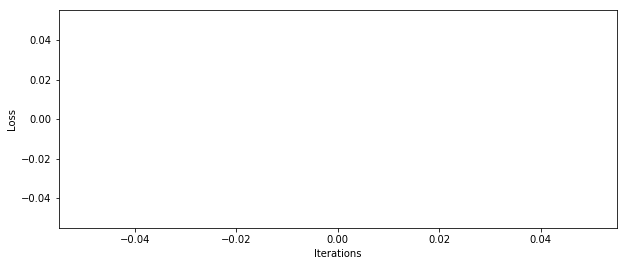

In [7]:
### 
### PREDICTIONS
###
tf.logging.set_verbosity(tf.logging.ERROR)

J = []
lam_opt = 0.01
THRESHOLD = 0.8


train({train_data_node: train_X, train_labels_node: train_y, lam: lam_opt},
      {train_data_node: val_X, train_labels_node: val_y, lam: lam_opt}, 
      THRESHOLD, 
      50)

# Show the fit and the loss over time.
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(J)))
ax1.plot(x, np.array(J).ravel())
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
plt.show()

In [31]:
###
### LEARNING CURVES FOR TRAINING SET AND CROSS-VALIDATION SET 
###
train_losses = []
val_losses = [0]
perc_losses = [0]
tf.logging.set_verbosity(tf.logging.ERROR)

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

myLam = 0.0
THRESHOLD = 0

for i in range(10,train_X.shape[0]+1,10):
    
    results = train({train_data_node: train_X[:i,:], train_labels_node: train_y[:i,:], lam: myLam},
            {train_data_node: val_X, train_labels_node: val_y, lam: myLam},
             THRESHOLD,
              1
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
    metrics["val_precision"].append(results["val_precision"]["mean"])
    metrics["val_recall"].append(results["val_recall"]["mean"])
    metrics["val_f"].append(results["val_f"]["mean"])
        
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
ax1.plot(x, np.array(metrics["train_loss"]).ravel())
ax1.plot(x, np.array(metrics["val_loss"]).ravel(),'r')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

 Training . .
Iterations : 1 Lambda : 0.00, Threshold : 0.00
Training loss : 0.00+/-0.00, precision : 1.00+/-0.00, recall : 1.00+/-0.00, F : 1.00+/-0.00
Validation loss : 89.01+/-0.00, precision : 0.53+/-0.00, recall : 1.00+/-0.00, F : 0.69+/-0.00
Training . .
Iterations : 1 Lambda : 0.00, Threshold : 0.00
Training loss : 0.00+/-0.00, precision : 1.00+/-0.00, recall : 1.00+/-0.00, F : 1.00+/-0.00
Validation loss : 45.88+/-0.00, precision : 0.54+/-0.00, recall : 1.00+/-0.00, F : 0.70+/-0.00
Training . .
Iterations : 1 Lambda : 0.00, Threshold : 0.00
Training loss : 0.00+/-0.00, precision : 1.00+/-0.00, recall : 1.00+/-0.00, F : 1.00+/-0.00
Validation loss : 54.66+/-0.00, precision : 0.53+/-0.00, recall : 1.00+/-0.00, F : 0.69+/-0.00
Training . .
Iterations : 1 Lambda : 0.00, Threshold : 0.00
Training loss : 0.00+/-0.00, precision : 1.00+/-0.00, recall : 1.00+/-0.00, F : 1.00+/-0.00
Validation loss : 81.07+/-0.00, precision : 0.58+/-0.00, recall : 1.00+/-0.00, F : 0.74+/-0.00
Training . 

KeyboardInterrupt: 

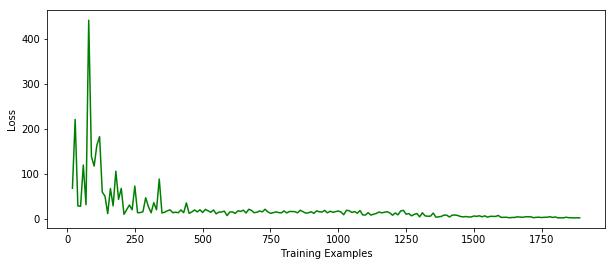

In [68]:
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
#ax1.plot(x, np.array(train_losses).ravel())
#ax1.plot(x, np.array(val_losses).ravel(),'r')
ax1.plot(x[2:], (np.array(((np.array(metrics["val_loss"])) ))[2:]).ravel(),'g')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

Training...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


Iterations : 10 Lambda : 0.00, Threshold : 0.90
Mean Validation loss : 2.04, precision : 0.62, recall : 0.67, F : 0.64
Sigma Validation loss : 0.38, precision : 0.03, recall : 0.08, F : 0.04
Training...
Iterations : 10 Lambda : 0.01, Threshold : 0.90
Mean Validation loss : 0.90, precision : 0.65, recall : 0.27, F : 0.38
Sigma Validation loss : 0.06, precision : 0.04, recall : 0.04, F : 0.03
Optimal value for lambda is 0.01


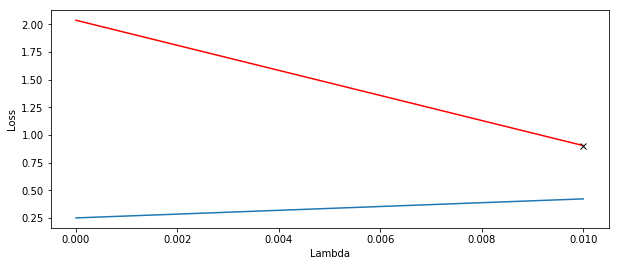

In [47]:
###
### LAMBDA OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

#lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]#, 0.3, 1.0, 3.0, 10.0]
#lams = np.arange(0.02,.04, .001)
lams = [0.0, 0.01]

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

for i in lams:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: i},
            {train_data_node: val_X, train_labels_node: val_y, lam: i},
             THRESHOLD,
              10
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
     

lam_opt = lams[np.argmin(metrics["val_loss"])]
print("Optimal value for lambda is %s" % lam_opt)
    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(lams, np.array(metrics["train_loss"]).ravel())
ax1.plot(lams, np.array(metrics["val_loss"]).ravel(),'r')
ax1.plot(lams[np.argmin(metrics["val_loss"])], metrics["val_loss"][np.argmin(metrics["val_loss"])], 'x', color='black')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Lambda")
plt.show()

In [37]:
###
### THRESHOLD OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

mylam = 0.0
threshold = 0
thresholds = [.5, .8, .9, .99, .999]
lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 1.0]

for i in thresholds:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: mylam},
            {train_data_node: val_X, train_labels_node: val_y, lam: mylam},
             i
            ) 
    
print("Done")


KeyboardInterrupt: 

In [ ]:
train_prediction.eval({train_data_node: val_X, train_labels_node: val_y, lam: 0})

In [ ]:
predictions = train_prediction.eval({train_data_node: val_X, train_labels_node: val_y, lam: 0})
np.argmax(predictions,axis=1)

In [ ]:
predictions = train_prediction.eval({train_data_node: test_X, train_labels_node: test_y, lam: 0})
np.argmax(predictions,axis=1)

In [ ]:
np.argmax(val_y,axis=1)